In [1]:
%config IPCompleter.use_jedi = False
# %xmode Verbose
# %xmode context
%pdb off
# %load_ext viztracer
# from viztracer import VizTracer
%load_ext autoreload
%autoreload 3
import sys
from pathlib import Path

# required to enable non-blocking interaction:
%gui qt5

from copy import deepcopy
# from numba import jit
import numpy as np
import pandas as pd
pd.options.mode.chained_assignment = None  # default='warn'
# pd.options.mode.dtype_backend = 'pyarrow' # use new pyarrow backend instead of numpy
from attrs import define, field, fields, Factory
import tables as tb
from datetime import datetime, timedelta

# Pho's Formatting Preferences
import builtins

import IPython
from IPython.core.formatters import PlainTextFormatter
from IPython import get_ipython

from pyphocorehelpers.preferences_helpers import set_pho_preferences, set_pho_preferences_concise, set_pho_preferences_verbose
from pyphocorehelpers.assertion_helpers import Assert

set_pho_preferences_concise()
# Jupyter-lab enable printing for any line on its own (instead of just the last one in the cell)
from IPython.core.interactiveshell import InteractiveShell
InteractiveShell.ast_node_interactivity = "all"

# from matplotlib.figure import Figure
import matplotlib.pyplot as plt
# from matplotlib.transforms import IdentityTransform
# %matplotlib qt
import numpy as np
# Set up numpy print options to only wrap at window width:
np.set_printoptions(edgeitems=30, linewidth=100000, formatter=dict(float=lambda x: "%g" % x)) # this somehow fucked up and caused rounding of my values...

from pyphocorehelpers.indexing_helpers import get_bin_centers
from pyphocorehelpers.gui.Qt.color_helpers import ColormapHelpers, ColorFormatConverter
from pyphoplacecellanalysis.External.pyqtgraph.colormap import ColorMap
from neuropy.utils.matplotlib_helpers import get_heatmap_cmap

Automatic pdb calling has been turned OFF


256

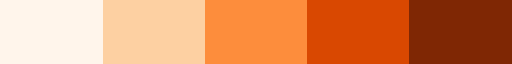

In [2]:
cmap = get_heatmap_cmap(cmap='Oranges', bad_color='black', under_color='white', over_color='red')
cmap.N
cmap.resampled(5)

color_idx_range: [0 1 2 3]


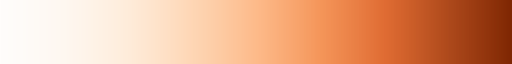

In [3]:
from matplotlib.colors import LinearSegmentedColormap

cmap_lut = ColormapHelpers.create_transparent_colormap(cmap_name='Oranges', lower_bound_alpha=0.2)
N_colors: int = np.shape(cmap_lut)[0]
cmap_lut = ColorFormatConverter.Colors_NDArray_Convert_to_zero_to_one_array(colors_ndarray=cmap_lut.T).T
cmap = LinearSegmentedColormap.from_list('CustomOranges', cmap_lut, N=N_colors)
cmap

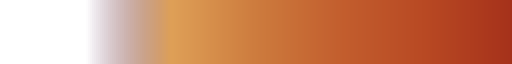

In [4]:
from neuropy.utils.external.cm_xml_to_matplotlib import load_cmap_from_xml_file
from pyphocorehelpers.gui.Qt.color_helpers import ColormapHelpers
# colormap_path = Path('/home/halechr/Downloads/colormap(2).json').resolve()
# Assert.file_exists(colormap_path)
# colormap_path = Path('C:/Users/pho/repos/Spike3DWorkEnv/Spike3D/EXTERNAL/PhoDibaPaper2024Book/data/colormaps/ccc-tool_colormap_yel15.csv').resolve()
# colormap_path = Path('C:/Users/pho/repos/Spike3DWorkEnv/Spike3D/EXTERNAL/PhoDibaPaper2024Book/data/colormaps/colormap.xml').resolve()
colormap_path = Path('C:/Users/pho/repos/Spike3DWorkEnv/Spike3D/EXTERNAL/PhoDibaPaper2024Book/data/colormaps/dropping_low_values_oranges_colormap.xml').resolve()
Assert.path_exists(colormap_path)
mycmap = load_cmap_from_xml_file(colormap_path)
mycmap = ColormapHelpers.create_colormap_transparent_below_value(mycmap, low_value_cuttoff=0.2)
mycmap


In [5]:
mycmap = 'Oranges'
mycmap = ColormapHelpers.create_colormap_transparent_below_value(mycmap, low_value_cuttoff=0.2)
mycmap


TypeError: 'ColorMap' object is not callable

In [ ]:


type(mycmap)
original_n_colors: int = mycmap.N
print(f'original_n_colors: {original_n_colors}')

# Get colors by sampling the colormap
# num_colors: int = 7  # Number of colors to extract
num_colors: int = original_n_colors  # Number of colors to extract

 #.__dict__
_resampled_cmap = mycmap.resampled(num_colors)

sampled_color_reference_arr = np.array([(float(i) / float(num_colors - 1)) for i in range(num_colors)]) ## array ranging between 0.0 and 1.0
sampled_color_reference_idxs = np.arange(len(sampled_color_reference_arr))
sampled_color_reference_arr

sampled_colors = np.array([list(_resampled_cmap(i / (num_colors - 1))) for i in range(num_colors)])
# sampled_colors.shape # (num_colors, 4)
sampled_colors


low_value_cuttoff = 0.2
is_value_below_cutoff = (sampled_color_reference_arr < low_value_cuttoff)
is_value_below_cutoff
# sampled_color_reference_arr[is_value_below_cutoff] ## values
below_cuttoff_indicies = sampled_color_reference_idxs[is_value_below_cutoff]
below_cuttoff_indicies
# sampled_colors[below_cuttoff_indicies][-1] = 0.0 # set alpha

sampled_colors[is_value_below_cutoff][-1] = 0.0 # set alpha

for idx in below_cuttoff_indicies:
    sampled_colors[idx][-1] = 0.0 # set alpha  

# sampled_colors[0][-1] = 0.0 # set alpha
sampled_colors

# Rebuild the colormap
reconstructed_cmap = LinearSegmentedColormap.from_list(f"reconstructed_{_resampled_cmap.name}", sampled_colors)
reconstructed_cmap


In [ ]:
import matplotlib.pyplot as plt
from matplotlib.colors import ListedColormap
import pandas as pd

## INPUTS: colormap_path

# Load the colormap data from the .csv file
colormap_data = pd.read_csv(colormap_path)

# Extract the RGB values from the .csv file
colors = colormap_data[['R', 'G', 'B']].values / 255.0  # Normalize the values to be between 0 and 1

# Create a ListedColormap object
custom_cmap = ListedColormap(colors)

# Plot a colorbar using the custom colormap
plt.colorbar(plt.cm.ScalarMappable(cmap=custom_cmap))
plt.show()

In [ ]:
import matplotlib.pyplot as plt
from matplotlib.widgets import Button

# Define the axis properties 
axis_properties = {
    'is_bad_epoch': False,
    'needs_review': True,
    'is_excluded': False,
    # ... Add other properties as needed.
}

# Function to toggle the properties and update the display
def toggle_property(event, property_name):
    axis_properties[property_name] = not axis_properties[property_name]
    update_display(property_name, buttons[property_name])

# Function to update the display/icons after each toggle
def update_display(property_name, button):
    # Here you could change the appearance of the button based on the state
    # For example, change the facecolor of the button:
    if axis_properties[property_name]:
        button.color = 'green'
    else:
        button.color = 'red'
    button.ax.figure.canvas.draw_idle()  # Redraw the button with new color

# Create your main plot here with Matplotlib
fig, ax = plt.subplots()

# Define the position for buttons. This has to be determined manually.
button_positions = {
    'is_bad_epoch': [0.1, 0.05, 0.1, 0.075],
    'needs_review': [0.25, 0.05, 0.1, 0.075],
    'is_excluded': [0.4, 0.05, 0.1, 0.075],
    # Define other positions as needed
}

buttons = {}  # Dictionary to hold buttons

for prop in axis_properties:
    button_ax = plt.axes(button_positions[prop])  # Define position for this button.
    button = Button(button_ax, prop)
    button.on_clicked(lambda event, prop=prop: toggle_property(event, prop))
    buttons[prop] = button
    update_display(prop, button)  # Initial update so buttons have the correct color

# Display the plot
plt.show()


In [ ]:
"""
There should be one bin per center, meaning that there should be 1+num bins edges
"""

def debug_print_shapes(*args, **kwargs):
    out_strings = []
    for i, an_ordered_arg in enumerate(args):
        out_strings.append(f'args[{i}]: np.shape: {np.shape(args[i])}')
    for key, val in kwargs.items():
        out_strings.append(f'{key}: np.shape: {np.shape(val)}')
    out_string = '\n'.join(out_strings)
    print(out_string)
    
    
# def test_simple_data():
#     # Please note that the histogram does not follow the Cartesian convention where x values are on the abscissa and y values on the ordinate axis. Rather, x is histogrammed along the first dimension of the array (vertical), and y along the second dimension of the array (horizontal).
#     raw_occupancy, xedges, yedges = np.histogram2d(x, y, bins=(xbin, ybin))
    
# def _check_bin_consistency(xbin_edges, ybin_edges, xbin_centers, ybin_centers):
    
    
num_x_bins = 100
num_y_bins = 15

num_x_bin_edges = num_x_bins + 1
num_y_bin_edges = num_y_bins + 1

xbin_edges = np.linspace(75.0, 400.0, num=num_x_bin_edges) # Get the bin values
ybin_edges = np.linspace(200.0, 240.0, num=num_y_bin_edges) # Get the bin values using fixed endpoints and a fixed number of bins.
xbin_centers = get_bin_centers(xbin_edges)
ybin_centers = get_bin_centers(ybin_edges)
# print(f'xbin_edges: {xbin_edges}\nxbin_centers: {xbin_centers}\nybin_edges: {ybin_edges}\nybin_centers: {ybin_centers}')

# Build the data matrix with one entry for each bin
matrix = np.zeros((len(xbin_centers), len(ybin_centers)))
# Add details to make it possible to tell orientation:
matrix[20, 10] = 1.0 # Here, the first index refers to the x-bin, and the second index refers to the y-bin.

debug_print_shapes(xbin_edges=xbin_edges, xbin_centers=xbin_centers, ybin_edges=ybin_edges, ybin_centers=ybin_centers, matrix=matrix)
""" the matrix is a [N_x x N_y] matrix, where the first axis corresponds to the x-value """

In [ ]:
def build_test_data_histogram_matrix():
    non_zero_point_xy = (xbin_centers[20], ybin_centers[10])
    test_x = [xbin_centers[20]]
    test_y = [ybin_centers[10]]
    print(f'non_zero_point_xy: {non_zero_point_xy}')
    matrix2, test_xedges, test_yedges = np.histogram2d(test_x, test_y, bins=(xbin_edges, ybin_edges))
    debug_print_shapes(test_xedges=test_xedges, test_yedges=test_yedges, matrix2=matrix2)
    return matrix2

matrix2 = build_test_data_histogram_matrix()
matrix2[20, 10] # using the same indexing scheme used for matrix, we can access the 1.0 element. That is to say that the x-axis is the first dimension, as we'd expect.
""" When our matrix is generated by passing the specific xbin_edges and ybin_edges to the histogram2d function, everyting is consistent with the x-axis as the first dimension, as we'd expect."""

In [ ]:
def build_test_data_histogram_matrix_num_bins():
    non_zero_point_xy = (xbin_centers[20], ybin_centers[10])
    test_x = [xbin_centers[20]]
    test_y = [ybin_centers[10]]
    print(f'non_zero_point_xy: {non_zero_point_xy}')
    matrix3, test_xedges, test_yedges = np.histogram2d(test_x, test_y, bins=(num_x_bins, num_y_bins))
    print(f'test_yedges: {test_yedges}')
    
    debug_print_shapes(test_xedges=test_xedges, test_yedges=test_yedges, matrix3=matrix3)
    return matrix3

matrix3 = build_test_data_histogram_matrix_num_bins()
matrix3[20, 10] # using the same indexing scheme used for matrix, we can access the 1.0 element. That is to say that the x-axis is the first dimension, as we'd expect.
""" When we instead build the histogram using the num_x_bins and num_y_bins, we get the same np.shape of result and number of bins, but the bin values themselves don't match and the indexing does not work. :[ """

In [ ]:
# Determine the point that lines up with the peak on the imshow matrix (which we know is artificially at the index [10, 10] of the matrix.

lin_max_idx = np.argmax(matrix) # it returns "1010", which doesn't seem right to me...
max_2d_idx = np.unravel_index(lin_max_idx, np.shape(matrix)) # correct, this returns (10, 10), which is expected.
print(f'max_2d_idx: {max_2d_idx}') # returns the same index as would be used to set a value of the matrix ([20, 10])
# To find how this relates to the specified xbins, we need to get the xbins at these corresponding values?
# The actual (x and y values these bins correspond to is determined by using the same indexing convention as defined before.
xbin_centers[max_2d_idx[0]]
ybin_centers[max_2d_idx[1]]


# Testing and Exploration:

In [ ]:
def test_plot_imshow(xbin, ybin, matrix):
    """ fig, ax, im_out = test_plot_imshow(xbin, ybin, matrix) """
    fig, axs = plt.subplots(ncols=2, nrows=2, figsize=(15,15), clear=True)
    # fig, axs = plt.subplots(ncols=2, nrows=2, figsize=(15,15), clear=True)
    # plt.subplots_adjust(left=0.25, bottom=0.25)
    variable_value = matrix
    frame = 0
    # main_plot_kwargs = {
    #     'cmap': 'viridis',
    #     'aspect':'auto',
    # }
    
    main_plot_kwargs = {
        'cmap': 'viridis',
        # 'aspect':'auto',
    }

    # xmin, xmax, ymin, ymax = (active_one_step_decoder.active_time_window_centers[0], active_one_step_decoder.active_time_window_centers[-1], active_one_step_decoder.xbin[0], active_one_step_decoder.xbin[-1])
    xmin, xmax, ymin, ymax = (xbin[0], xbin[-1], ybin[0], ybin[-1])
    # xmin, xmax, ymin, ymax = (active_one_step_decoder.ybin[0], active_one_step_decoder.ybin[-1], active_one_step_decoder.xbin[0], active_one_step_decoder.xbin[-1]) # Reversed x and y axes, seems not good.
    extent = (xmin, xmax, ymin, ymax)
    
    ax = axs[0,0]
    im_out = ax.imshow(variable_value, extent=extent, **main_plot_kwargs, origin='lower')
    ax.set_title(f'origin=lower \nextent=(xmin, xmax, ymin, ymax): {extent}')
    ax.set_xlabel('x')
    ax.set_ylabel('y')
    # ax.axis("off")
    
    ax = axs[0,1]
    im_out = ax.imshow(variable_value, extent=extent, **main_plot_kwargs, origin='upper')
    ax.set_title(f'origin=upper \nextent=(xmin, xmax, ymin, ymax): {extent}')
    ax.set_xlabel('x')
    ax.set_ylabel('y')
    
    """
    Note that changing the origin while keeping everything else the same doesn't flip the direction of the yaxis labels despite flipping the yaxis of the data.
    """
    
    y_first_extent = (ymin, ymax, xmin, xmax) # swapped the order of the extent axes.
    
    ax = axs[1,0]
    im_out = ax.imshow(variable_value, extent=y_first_extent, **main_plot_kwargs, origin='lower')
    ax.set_title(f'origin=lower \nextent=(ymin, ymax, xmin, xmax): {y_first_extent}')
    ax.set_xlabel('x')
    ax.set_ylabel('y')
    # ax.axis("off")
    
    ax = axs[1,1]
    im_out = ax.imshow(variable_value, extent=y_first_extent, **main_plot_kwargs, origin='upper')
    ax.set_title(f'origin=upper \nextent=(ymin, ymax, xmin, xmax): {y_first_extent}')
    ax.set_xlabel('x')
    ax.set_ylabel('y')
    
    # plt.title(f'debug_two_step: {variable_name}')
    return fig, axs, im_out

def test_add_point(test_point, ax):
    """ line = test_add_point(test_point, ax) """
    line, = ax.plot(test_point[0], test_point[1], marker='d', markersize=40.0, linestyle='None', color='red')
    return line

def setup_stable_axes_limits(xbins, ybins, ax):
    " manually sets the axis data limits to disable autoscaling given the xbins/ybins "
    ax.set_xlim(left=xbins[0], right=xbins[-1])
    ax.set_ylim(bottom=ybins[0], top=ybins[-1])
    

In [ ]:
xbin_centers[-1]

In [ ]:
plt.matshow(matrix)
plt.title('How the matrix is actually represented by numpy in memory')
plt.xlabel('column, second dimension of arr')
plt.ylabel('row, first dimension of array')

In [ ]:
# Perform the plot:
fig, ax, plot_im_out = test_plot_imshow(xbin_edges, ybin_edges, matrix)
plt.suptitle('Flipping the extents has no effect at all on the data, although the origin does.')

In [ ]:
test_point = [20, 10]
# Perform the plot:
fig, axs, plot_im_out = test_plot_imshow(xbin_edges, ybin_edges, matrix)
plot_point = test_add_point(test_point, axs[0][0])
plot_point = test_add_point(test_point, axs[0][1])
plot_point = test_add_point(test_point, axs[1][0])
plot_point = test_add_point(test_point, axs[1][1])
plt.suptitle('Plotting the test_point at the indicies into the matrix causes the view to mess up')

In [ ]:
test_point = [80.0, 210.0]
# Perform the plot:
fig, axs, plot_im_out = test_plot_imshow(xbin_edges, ybin_edges, matrix)
plot_point = test_add_point(test_point, axs[0][0])
plot_point = test_add_point(test_point, axs[0][1])
plot_point = test_add_point(test_point, axs[1][0])
plot_point = test_add_point(test_point, axs[1][1])
plt.suptitle('Changing the origin from lower to upper has no effect on the plotted test_points (by plot). at the indicies into the matrix causes the view to mess up')

## The extent set by imshow DOES impact the effect of plotting points with plot(...) on the other hand!

In [ ]:
# test_point = [xbin[max_2d_idx[0]], ybin[max_2d_idx[1]]]
# test_point = [xbin[max_2d_idx[1]], ybin[max_2d_idx[0]]] # IndexError: index 20 is out of bounds for axis 0 with size 15
test_point = [ybin_edges[max_2d_idx[1]], xbin_edges[max_2d_idx[0]]]
# Perform the plot:
fig, axs, plot_im_out = test_plot_imshow(xbin_edges, ybin_edges, matrix)
plot_point = test_add_point(test_point, axs[0][0])
plot_point = test_add_point(test_point, axs[0][1])
plot_point = test_add_point(test_point, axs[1][0])
plot_point = test_add_point(test_point, axs[1][1])
plt.suptitle('Changing the origin from lower to upper has no effect on the plotted test_points (by plot). at the indicies into the matrix causes the view to mess up')

## See that only the bottom left plot works!

# Working Configuration:
The only configuration that makes the points line up with the underlying heatmap requires:

1. The origin must be set to `origin=lower`
2. The extents passed to imshow must be set in the form: `y_first_extent = (ymin, ymax, xmin, xmax)`
3. points passed into plot are specified as `plot(y_val, x_val)` instead of the customary `plot(x_val, y_val)`. This can be done by building them this way, or flipping the inputs to plot.
4. you should NOT set 'aspect='auto'' if you want to preserve the original data shape.
5. You need to reverse your calls to ax.set_xlabel and ax.set_ylabel, e.g.: ax.set_xlabel('ACTUALLY Y LABEL')

# Note that despite the image being right, the xlabels and ylabels are now WRONG. They're flipped for some reason!

# Disable autoscaling to get exactly the plot we want:
ax.autoscale(enable=None, axis="x", tight=True) # the tight=true disables margins (which I don't see why we'd need them)
ax.autoscale(enable=None, axis="y", tight=True) 

In [ ]:
setup_stable_axes_limits(xbin_edges, ybin_edges, ax[0,0]) # note that the data bounds should be from xbin, not xbin_centers, even though the data should have been computed only on xbin_centers

# Final Working Plot

In [ ]:
# The simple goal is to be able to plot a heatmap, for example one obtained from a 2D histogram of x and y data, and plot it with relevant points overlaying it.

def final_x_vertical_plot_imshow(xbin_edges, ybin_edges, matrix):
    """ Plots the matrix data in the 'x == vertical orientation'
    
    fig, ax, im_out = good_plot_imshow(xbin, ybin, matrix) """
    def setup_stable_axes_limits(xbins_edges, ybin_edges, ax):
        " manually sets the axis data limits to disable autoscaling given the xbins_edges/ybin_edges "
        # x == vertical orientation:
        ax.set_xlim(left=ybin_edges[0], right=ybin_edges[-1])
        ax.set_ylim(bottom=xbins_edges[0], top=xbins_edges[-1])
        # x == horizontal orientation:
        # ax.set_xlim(left=xbins_edges[0], right=xbins_edges[-1])
        # ax.set_ylim(bottom=ybin_edges[0], top=ybin_edges[-1])

    fig, axs = plt.subplots(ncols=1, nrows=1, figsize=(15,15), clear=True)
    variable_value = matrix
    
    xmin, xmax, ymin, ymax = (xbin_edges[0], xbin_edges[-1], ybin_edges[0], ybin_edges[-1])
    y_first_extent = (ymin, ymax, xmin, xmax) # swapped the order of the extent axes.
    main_plot_kwargs = {
        'cmap': 'viridis',
        'origin':'lower',
        'extent':y_first_extent,
    }
    
    """
    Note that changing the origin while keeping everything else the same doesn't flip the direction of the yaxis labels despite flipping the yaxis of the data.
    """
    ax = axs
    im_out = ax.imshow(variable_value, **main_plot_kwargs)
    ax.set_title(f'origin=lower \nextent=(ymin, ymax, xmin, xmax): {y_first_extent}')
    # Note that the xlabel and ylabel commands are for the opposite axis!
    ax.set_xlabel('y')
    ax.set_ylabel('x')
    setup_stable_axes_limits(xbin_edges, ybin_edges, ax)
    return fig, axs, im_out

def final_x_vertical_add_point(test_point_x_y, ax):
    """ Plots the data point/points in the 'x == vertical orientation':
    line = good_add_point(test_point, test_point[0], ax) """
    line, = ax.plot(test_point_x_y[1], test_point_x_y[0], marker='d', markersize=40.0, linestyle='None', color='red', alpha=0.5)
    return line


In common usage, the abscissa refers to the horizontal axis and the ordinate refers to the vertical axis of a standard two-dimensional graph. 


In [ ]:
from pyphocorehelpers.plotting.image_plotting_helpers import IMShowHelpers

test_point = [xbin_centers[max_2d_idx[0]], ybin_centers[max_2d_idx[1]]] # why wouldn't this be x_bin center if it corresponds to an entry in the matrix with each point corresponding to a center?

# Perform the plot:
fig, axs, plot_im_out = IMShowHelpers.final_x_vertical_plot_imshow(xbin_edges, ybin_edges, matrix)
plot_point = IMShowHelpers.final_x_vertical_add_point(test_point, axs)
plt.suptitle('Final x == vertical axis Plot')


# Attempt to convert data to typical x == horizontal axis plot:

In [ ]:
IMShowHelpers.

In [ ]:
# Either of these approaches work to format the output in a form that final_x_horizontal_* functions can use:
# x_horizontal_matrix = np.swapaxes(matrix, 0, 1)
x_horizontal_matrix = matrix.T

# Perform the plot:
fig, axs, plot_im_out = IMShowHelpers.final_x_horizontal_plot_imshow(xbin_edges, ybin_edges, x_horizontal_matrix)
plot_point = IMShowHelpers.final_x_horizontal_add_point(test_point, axs)
plt.suptitle('Final x == horizontal axis Plot')